# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions
from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVM import QSVM_QKE

seed = 12345

# Blobs dataset

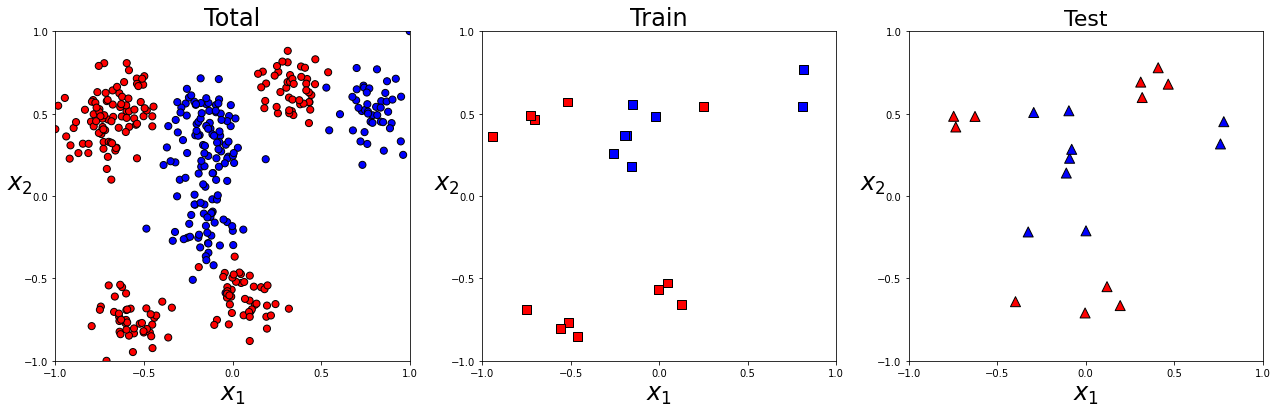

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

n_samples = 400
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=9, random_state=110, shuffle=True, cluster_std=1.2)
y[y%2 == 0] = -1
y[y > 0] = 1

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax)).fit_transform(X)
axes = [xmin, xmax, xmin, xmax]

train_size = 20
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

Best grid search parameters: {'C': 1, 'gamma': 10.0}
Best training score: 0.875


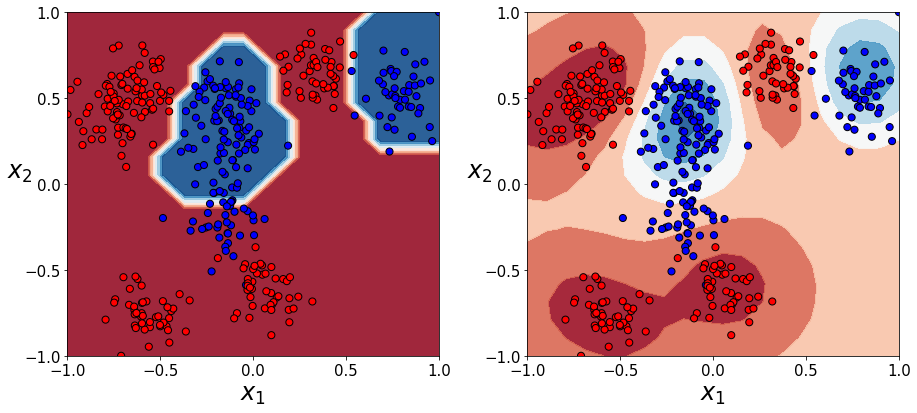

In [3]:
param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [4]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    
    print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

rnd seed 20962
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 11749
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 64797
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 2177
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 19876
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  0.9545454545454546

Train set:
   Balanced accuracy:  0.96 +- 0.05
                  F1:  0.96 +- 0.06
             ROC_AUC:  0.98 +- 0.05

Test set:
   Balanced accuracy:  0.85 +- 0.08
                  F1:  0.84 +- 0.08
             ROC_AUC:  0.90 +- 0.14


In [10]:
scores_ = get_scores(best_clf, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.94
                  F1:  0.94
             ROC_AUC:  0.99


## Best RBF CV Predictions/Decision boundaries plot

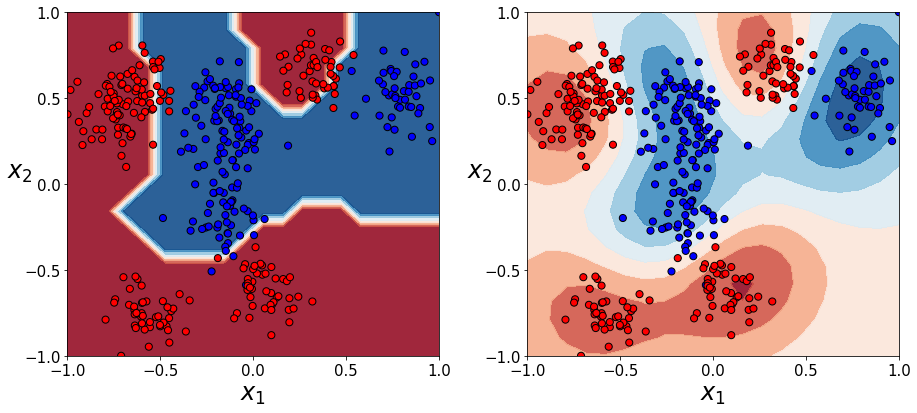

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_clf, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_clf, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# QKE SVM

     ┌───┐ ┌──────────────┐ ┌───┐ ┌──────────────┐ 
q_0: ┤ H ├─┤ Rz(3.1*x[0]) ├─┤ H ├─┤ Rz(3.1*x[0]) ├─
     ├───┤ ├──────────────┤ ├───┤ ├──────────────┤ 
q_1: ┤ H ├─┤ Rz(3.1*x[1]) ├─┤ H ├─┤ Rz(3.1*x[1]) ├─
     └───┘ └──────────────┘ └───┘ └──────────────┘ 

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00


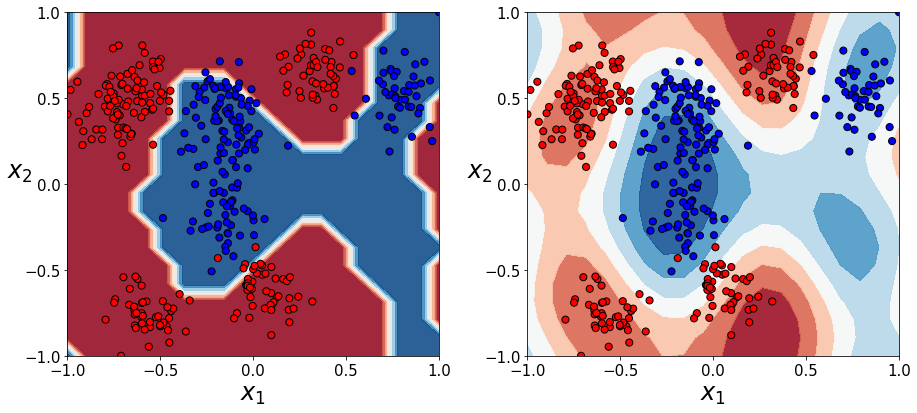

In [6]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['H', 'RZ', ], entanglement='full',
    repeat=True,
    scale=False, alpha=3.1,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    
    print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        print(f"Train/Test CV Subset {i}")
        
        qsvc = QSVM_QKE(fm, X[train,:], y[train], seed=_seed)
        
        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

rnd seed 20962
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 11749
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 64797
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 2177
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 19876
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.94 +- 0.05
                  F1:  0.93 +- 0.06
             ROC_AUC:  0.99 +- 0.02

Test set:
   Balanced accuracy:  0.89 +- 0.09
                  F1:  0.87 +- 0.10
             ROC_AUC:  0.96 +- 0.04


In [9]:
scores_ = get_scores(best_qsvc, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.99


## Best QSVM CV Predictions/Decision boundaries plot

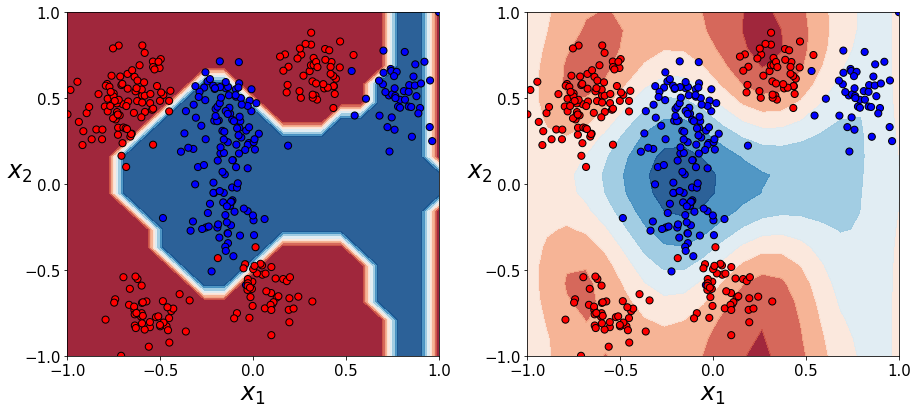

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()